In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

In [2]:
df2 = pd.read_csv('source/FReDA2.csv')

In [7]:
df2['Anchor Age group'].value_counts()

Anchor Age group
3.0    2909
4.0    1935
2.0    1634
5.0     207
1.0     114
Name: count, dtype: int64

In [8]:
def clean_touch_values(series):
    return np.where(
        (series > 0) & (series < 1), 1,
        np.where((series < 0) & (series > -1), -1, np.round(series))
    )


col_names = [
    'Anchor Frequency of Touch',
    'Partner Frequency of Touch',
    'Anchor Wish for Touch',
    'Partner Wish for Touch'
]

for col in col_names:
    df2[col] = clean_touch_values(df2[col])

In [9]:
def compute_discrepancy(target, anchor_col, partner_col, new_col):
    diff = target[anchor_col] - target[partner_col]
    target[new_col] = np.select(
        condlist=[
            diff == 0,
            diff > 2,
            diff > 0,
            diff < -2,
            diff < 0
        ],
        choicelist=[0, 2, 1, -2, -1],
        default=np.nan
    )


compute_discrepancy(df2, 'Anchor Frequency of Touch', 'Partner Frequency of Touch', 'Frequency Discrepancy')
compute_discrepancy(df2, 'Anchor Wish for Touch', 'Partner Wish for Touch', 'Wish Discrepancy')
compute_discrepancy(df2, 'Anchor Kiss Frequency', 'Partner Kiss Frequency', 'Kiss Discrepancy')
compute_discrepancy(df2, 'Anchor Hold Frequency', 'Partner Hold Frequency', 'Hold Discrepancy')
compute_discrepancy(df2, 'Anchor Hug Frequency', 'Partner Hug Frequency', 'Hug Discrepancy')

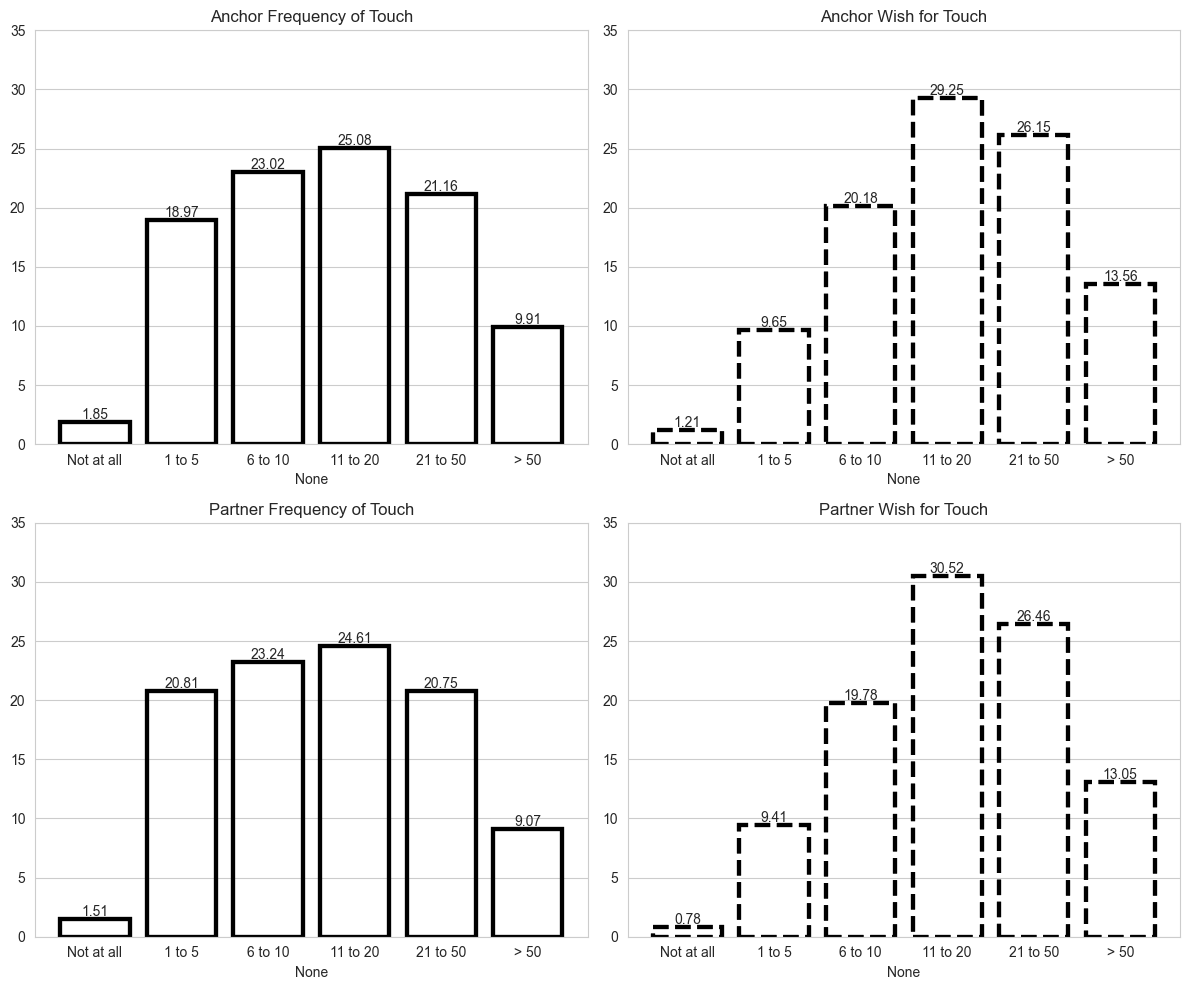

In [10]:
def calculate_freq(input_var):
    n = df2[input_var].count()
    m = [
        np.sum(df2[input_var] < 1),
        np.sum((df2[input_var] >= 1) & (df2[input_var] < 2)),
        np.sum((df2[input_var] >= 2) & (df2[input_var] < 3)),
        np.sum((df2[input_var] >= 3) & (df2[input_var] < 4)),
        np.sum((df2[input_var] >= 4) & (df2[input_var] < 5)),
        np.sum(df2[input_var] >= 5)
    ]
    temp_df = pd.DataFrame({
        input_var: [round((m[0] * 100) / n, 2),
                    round((m[1] * 100) / n, 2),
                    round((m[2] * 100) / n, 2),
                    round((m[3] * 100) / n, 2),
                    round((m[4] * 100) / n, 2),
                    round((m[5] * 100) / n, 2)]
    },
        index=["Not at all",
               "1 to 5",
               "6 to 10",
               "11 to 20",
               "21 to 50",
               "> 50"])

    return temp_df

var_names = ['Anchor Frequency of Touch',
             'Anchor Wish for Touch',
             'Partner Frequency of Touch',
             'Partner Wish for Touch',
             # 'Anchor Kiss Frequency',
             # 'Anchor Kiss Wish',
             # 'Partner Kiss Frequency',
             # 'Partner Kiss Wish',
             # 'Anchor Hold Frequency',
             # 'Anchor Hold Wish',
             # 'Partner Hold Frequency',
             # 'Partner Hold Wish',
             # 'Anchor Hug Frequency',
             # 'Anchor Hug Wish',
             # 'Partner Hug Frequency',
             # 'Partner Hug Wish',
             ]

labels = ["Not at all",
          "1 to 5",
          "6 to 10",
          "11 to 20",
          "21 to 50",
          "> 50", ]

frequency_map = pd.DataFrame({}, index=labels)

for i, label in enumerate(var_names):
    a = calculate_freq(label)
    frequency_map = pd.concat([frequency_map, a], axis=1)

cols = frequency_map.columns.tolist()

lines_w = 3

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # flatten to index as 0,1,2,3 instead of [row, col]

for i, name in enumerate(cols):
    ax = axes[i]

    sns.barplot(
        x=frequency_map[name].index,
        y=frequency_map[name].values,
        ax=ax,
        linewidth=lines_w,
        edgecolor='k',
        facecolor=(0, 0, 0, 0)
    )
    multiplier = 0
    for attribute, measurement in frequency_map[cols[i]].items():
        offset = multiplier
        rects = ax.bar(offset,
                       measurement,
                       label=attribute,
                       edgecolor='k',
                       facecolor=(0, 0, 0, 0)
                       )
        ax.bar_label(rects)
        multiplier += 1
    if i % 2 == 1:
        for bar in ax.patches:
            bar.set_linestyle('--')
            bar.set_linewidth(lines_w)
    elif i % 2 == 0:
        for bar in ax.patches:
            bar.set_linestyle('-')
            bar.set_linewidth(lines_w)

    ax.set_title(name)
    ax.set_ylim(0, 35)

plt.tight_layout()
plt.show()

# plt.savefig('output/img_bg/frequency/' + name + '.png', dpi=350, transparent=False, bbox_inches='tight')

In [11]:
desired_order = {5: 'More than 50 times',
                 4: '21 to 50 times',
                 3: '11 to 20 times',
                 2: '6 to 10 times',
                 1: '1 to 5 times',
                 0: "Not at all"}

colors = ["#1d91c0", "#41b6c4", "#7fcdbb", "#a1dab4", "#ffffd9", "#253494"]
reversed_colors = colors[::-1]

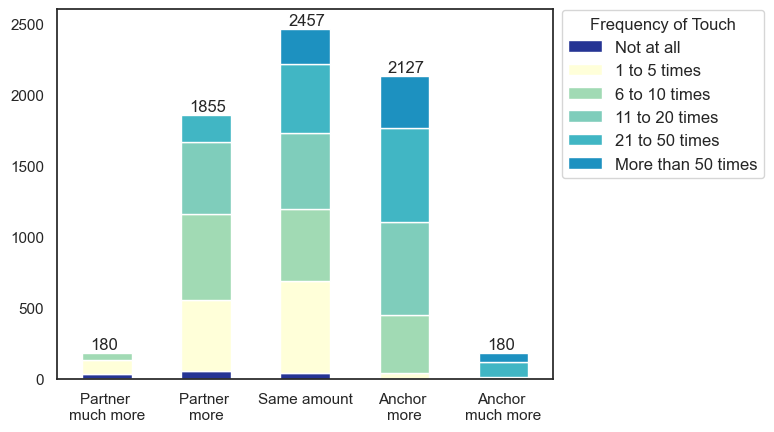

In [13]:
sns.set_theme(style='white')
ct = pd.crosstab(df2['Frequency Discrepancy'], df2['Anchor Frequency of Touch'])
ct.rename(desired_order, axis='columns', inplace=True)

ax = ct.plot(kind='bar', stacked=True, rot=0, color=reversed_colors)

ax.legend(title='Frequency of Touch', bbox_to_anchor=(1, 1.02), loc='upper left', fontsize=12)

a = df2.value_counts("Frequency Discrepancy").sort_index()

for i, label in enumerate(list(a)):
    ax.annotate(str(label), (i - 0.17, label + 30))

labels = ["Partner \nmuch more",
          "Partner \nmore",
          "Same amount",
          "Anchor \nmore",
          "Anchor \nmuch more"
          ]

plt.xticks(range(5), labels=labels, rotation=0)
plt.xlabel("")
plt.ylim([0, 2600])
plt.grid(False)
plt.show()
# plt.savefig('output/img_bg/comparisons/anchor_frequency_of_touch.png', dpi=350, transparent=False, bbox_inches='tight')
plt.close()

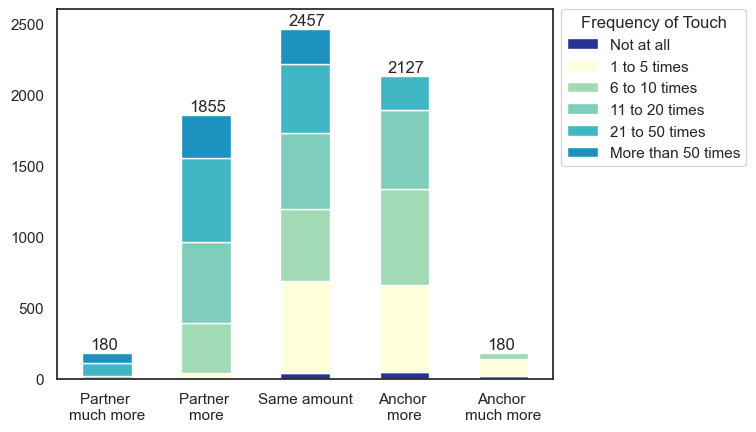

In [14]:
sns.set_theme(style='white')
ct = pd.crosstab(df2['Frequency Discrepancy'], df2['Partner Frequency of Touch'])
ct.rename(desired_order, axis='columns', inplace=True)

ax = ct.plot(kind='bar', stacked=True, rot=0, color=reversed_colors)
ax.legend(title='Frequency of Touch', bbox_to_anchor=(1, 1.02), loc='upper left')

a = df2.value_counts("Frequency Discrepancy").sort_index()

for i, label in enumerate(list(a)):
    ax.annotate(str(label), (i - 0.17, label + 30))

labels = ["Partner \nmuch more",
          "Partner \nmore",
          "Same amount",
          "Anchor \nmore",
          "Anchor \nmuch more"
          ]

plt.xticks(range(5), labels=labels)
plt.xlabel("")
plt.ylim([0, 2600])
plt.grid(False)
plt.show()
# plt.savefig('output/img_bg/comparisons/partner_frequency_of_touch.png', dpi=350, transparent=False, bbox_inches='tight')
plt.close()

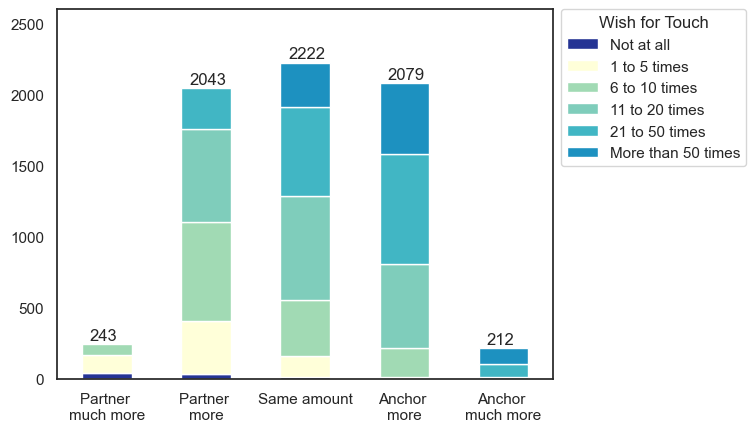

In [15]:
sns.set_theme(style='white')
ct = pd.crosstab(df2['Wish Discrepancy'], df2['Anchor Wish for Touch'])
ct.rename(desired_order, axis='columns', inplace=True)

ax = ct.plot(kind='bar', stacked=True, rot=0, color=reversed_colors)
ax.legend(title='Wish for Touch', bbox_to_anchor=(1, 1.02), loc='upper left')
#
a = df2.value_counts("Wish Discrepancy").sort_index()

for i, label in enumerate(list(a)):
    ax.annotate(str(label), (i - 0.17, label + 30))

labels = ["Partner \nmuch more",
          "Partner \nmore",
          "Same amount",
          "Anchor \nmore",
          "Anchor \nmuch more"
          ]

plt.xticks(range(5), labels=labels)
plt.xlabel("")
plt.ylim([0, 2600])
plt.grid(False)
plt.show()
# plt.savefig('output/img_bg/comparisons/anchor_wish_for_touch.png', dpi=350, transparent=False, bbox_inches='tight')
plt.close()

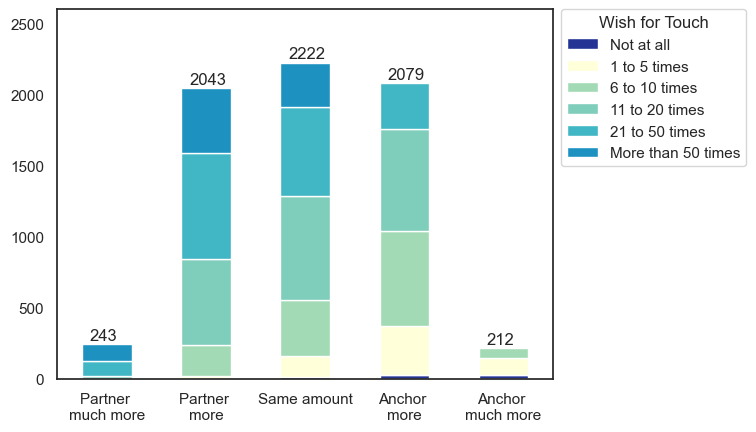

In [16]:
sns.set_theme(style='white')
ct = pd.crosstab(df2['Wish Discrepancy'], df2['Partner Wish for Touch'])
ct.rename(desired_order, axis='columns', inplace=True)

ax = ct.plot(kind='bar', stacked=True, rot=0, color=reversed_colors)
ax.legend(title='Wish for Touch', bbox_to_anchor=(1, 1.02), loc='upper left')

a = df2.value_counts("Wish Discrepancy").sort_index()

for i, label in enumerate(list(a)):
    ax.annotate(str(label), (i - 0.17, label + 30))

labels = ["Partner \nmuch more",
          "Partner \nmore",
          "Same amount",
          "Anchor \nmore",
          "Anchor \nmuch more"
          ]

plt.xticks(range(5), labels=labels)
plt.xlabel("")
plt.ylim([0, 2600])
plt.grid(False)
plt.show()
# plt.savefig('output/img_bg/comparisons/partner_wish_for_touch.png', dpi=350, transparent=False, bbox_inches='tight')
plt.close()

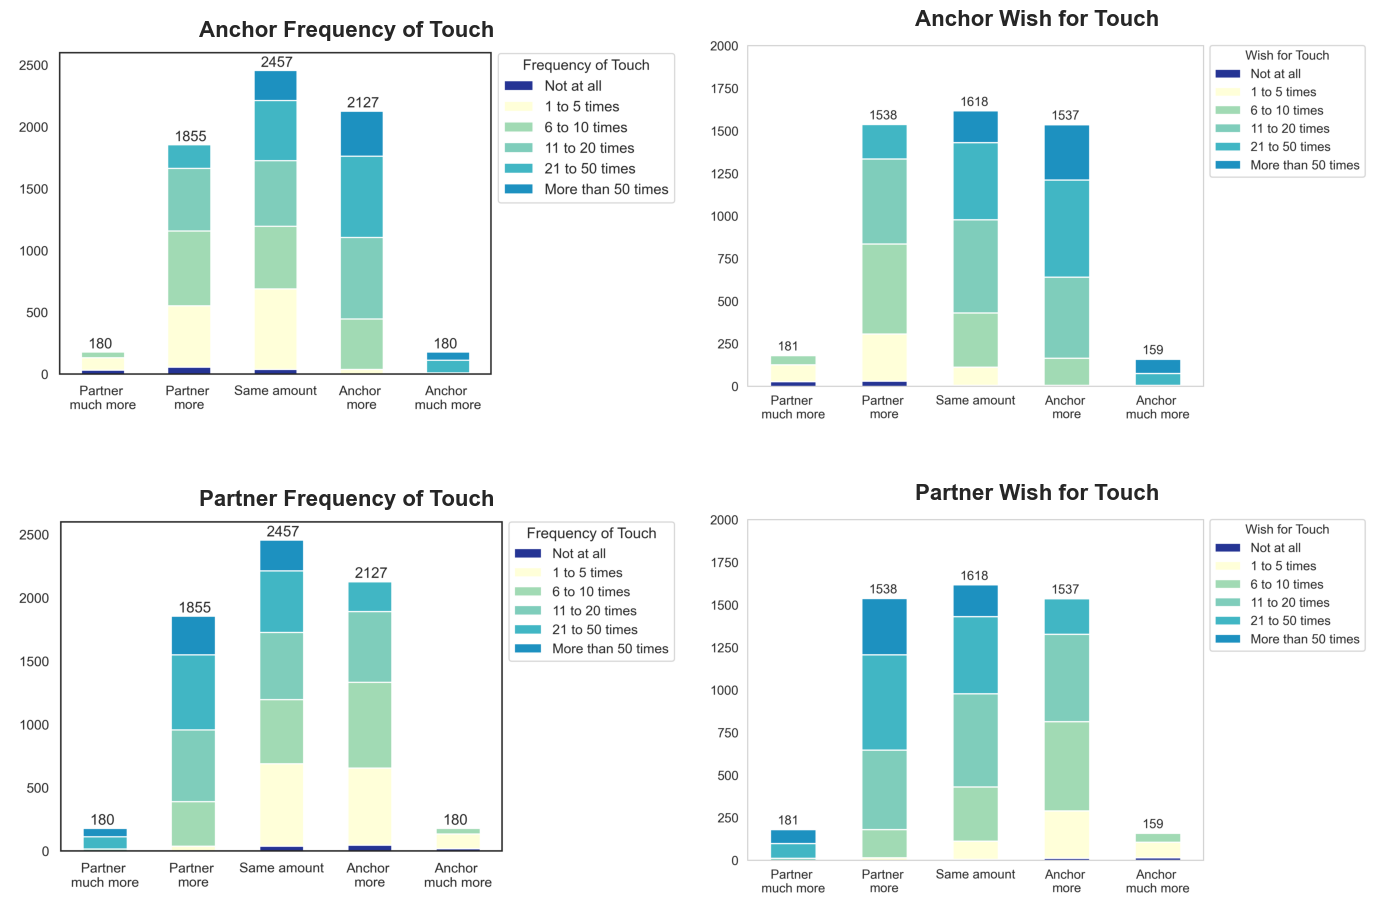

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0][0].imshow(plt.imread("output/img_bg/comparisons/anchor_frequency_of_touch.png"))
axes[0][0].axis("off")
axes[0][0].set_title("Anchor Frequency of Touch", fontsize=16, fontweight="bold")
axes[0][1].imshow(plt.imread("output/img_bg/comparisons/anchor_wish_for_touch.png"))
axes[0][1].axis("off")
axes[0][1].set_title("Anchor Wish for Touch", fontsize=16, fontweight="bold")
axes[1][0].imshow(plt.imread("output/img_bg/comparisons/partner_frequency_of_touch.png"))
axes[1][0].axis("off")
axes[1][0].set_title("Partner Frequency of Touch", fontsize=16, fontweight="bold")
axes[1][1].imshow(plt.imread("output/img_bg/comparisons/partner_wish_for_touch.png"))
axes[1][1].axis("off")
axes[1][1].set_title("Partner Wish for Touch", fontsize=16, fontweight="bold")
plt.tight_layout()
# plt.subplots_adjust(wspace=-0.2, hspace=0.1)
plt.show()

In [18]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
temp1 = 'Anchor Perception of Touch'
temp2 = 'Partner Perception of Touch'

kde_configs = [
    {
        "source": temp1,
        "x": "Anchor Frequency of Touch",
        "palette": sns.cubehelix_palette(10, rot=-.25, light=.7),
        "outfile": "output/img_bg/kde/anchor_perception_freq.png",
    },
    {
        "source": temp1,
        "x": "Anchor Wish for Touch",
        "palette": sns.cubehelix_palette(10, start=0.0, rot=0.3, light=0.85, dark=0.1, gamma=1.0),
        "outfile": "output/img_bg/kde/anchor_perception_wish.png",
    },
    {
        "source": temp2,
        "x": "Partner Frequency of Touch",
        "palette": sns.cubehelix_palette(10, rot=-.25, light=.7),
        "outfile": "output/img_bg/kde/partner_perception_freq.png",
    },
    {
        "source": temp2,
        "x": "Partner Wish for Touch",
        "palette": sns.cubehelix_palette(10, start=0.0, rot=0.3, light=0.85, dark=0.1, gamma=1.0),
        "outfile": "output/img_bg/kde/partner_perception_wish.png",
    },
]

for config in kde_configs:
    source = config["source"]
    x_var = config["x"]
    palette = config["palette"]
    outfile = config["outfile"]

    g = sns.FacetGrid(
        data=df2,
        row=source,
        hue=source,
        aspect=4,
        height=2,
        palette=palette
    )

    g.map(sns.kdeplot,
          x_var,
          bw_adjust=0.5,
          clip_on=False,
          fill=True,
          alpha=1,
          linewidth=1.5)

    g.map(sns.kdeplot,
          x_var,
          color="k",
          clip_on=False,
          lw=2,
          bw_adjust=0.5)

    g.refline(y=0, linewidth=2, linestyle="-", color="k", clip_on=False)


    def label(x, color, label):
        ax = plt.gca()
        ax.text(1, .1, label, fontweight="bold", color="b",
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, temp1)
    g.figure.subplots_adjust(hspace=-.5)

    g.set_titles("")
    g.set_xlabels("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    plt.xticks(
        ticks=[0, 1, 2, 3, 4, 5],
        labels=[
            "Not at all",
            '1 to 5 times',
            '6 to 10 times',
            '11 to 20 times',
            '21 to 50 times',
            'More than 50 times',
        ],
        rotation=15
    )

    plt.title("")

    # plt.savefig(outfile, dpi=350, transparent=False, bbox_inches='tight')
    plt.close()

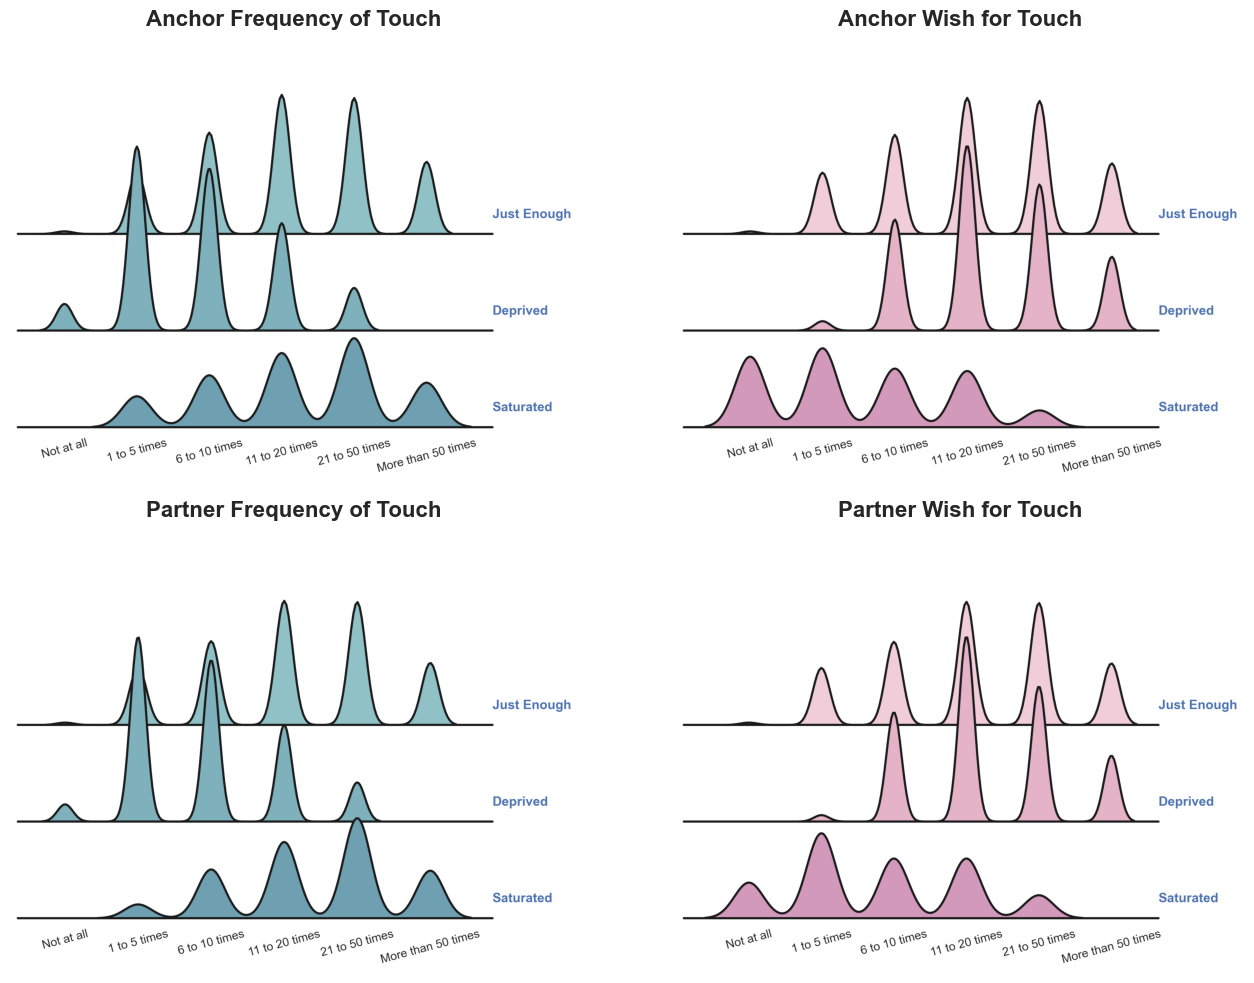

In [19]:
# Load and combine using matplotlib (or use external tools like Illustrator)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes[0][0].imshow(plt.imread("output/img_bg/kde/anchor_perception_freq.png"))
axes[0][0].axis("off")
axes[0][0].set_title("Anchor Frequency of Touch", fontsize=16, fontweight="bold")
axes[0][1].imshow(plt.imread("output/img_bg/kde/anchor_perception_wish.png"))
axes[0][1].axis("off")
axes[0][1].set_title("Anchor Wish for Touch", fontsize=16, fontweight="bold")
axes[1][0].imshow(plt.imread("output/img_bg/kde/partner_perception_freq.png"))
axes[1][0].axis("off")
axes[1][0].set_title("Partner Frequency of Touch", fontsize=16, fontweight="bold")
axes[1][1].imshow(plt.imread("output/img_bg/kde/partner_perception_wish.png"))
axes[1][1].axis("off")
axes[1][1].set_title("Partner Wish for Touch", fontsize=16, fontweight="bold")
plt.tight_layout()
# plt.subplots_adjust(wspace=-0.2, hspace=0.1)
plt.show()

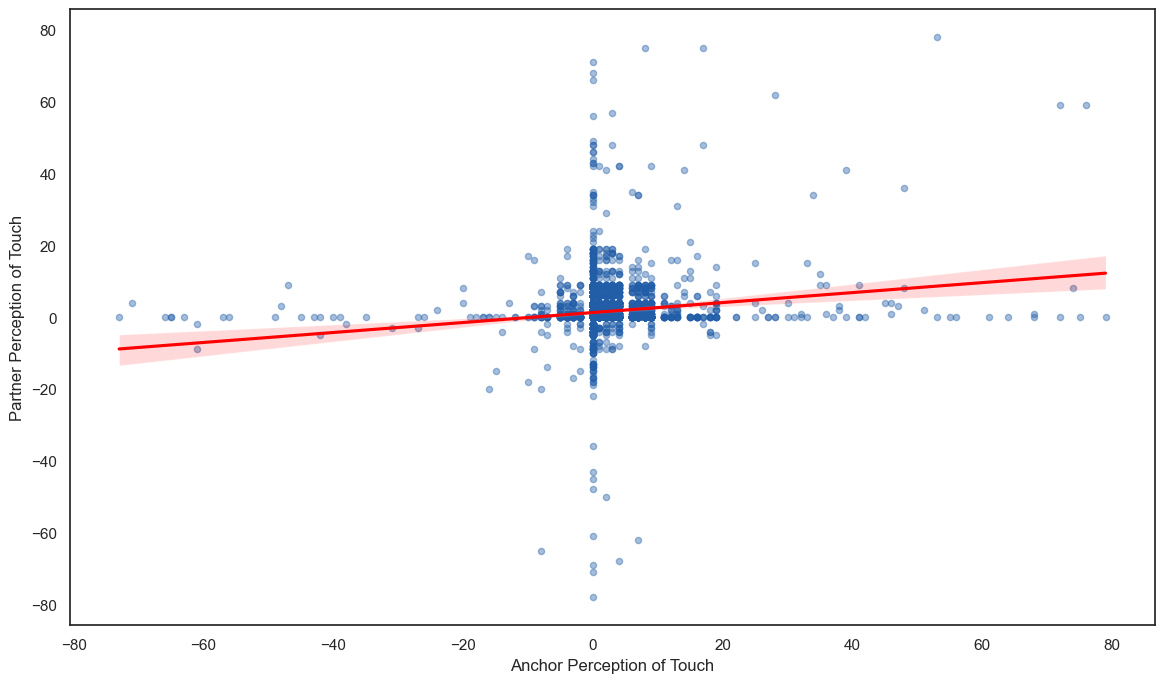

In [18]:
def map_to_random_value(response):
    if response == 0:
        return 0
    elif response == 1:
        return np.random.randint(1, 5)
    elif response == 2:
        return np.random.randint(6, 10)
    elif response == 3:
        return np.random.randint(11, 20)
    elif response == 4:
        return np.random.randint(21, 50)
    elif response == 5:
        return np.random.randint(51, 80)
    elif response == -1:
        return np.random.randint(-5, -1)
    elif response == -2:
        return np.random.randint(-10, -6)
    elif response == -3:
        return np.random.randint(-20, -11)
    elif response == -4:
        return np.random.randint(-50, -21)
    elif response == -5:
        return np.random.randint(-80, -51)
    else:
        return np.nan


df2["x_value"] = df2["Anchor Difference of Touch"].apply(map_to_random_value)
df2["y_value"] = df2["Partner Difference of Touch"].apply(map_to_random_value)

plt.figure(figsize=(14, 8))
plt.tight_layout()
sns.regplot(data=df2, x="x_value", y="y_value",
            scatter_kws={'alpha': 0.4, 's': 20, 'color': "#225ea8"},
            line_kws={'color': 'red'},
            order=1,
            # x_jitter=0.1
            )

plt.xlabel("Anchor Perception of Touch")
plt.ylabel("Partner Perception of Touch")

plt.grid(False)
# plt.savefig('output/img_bg/scatter/scatter_anchor_partner.png', dpi=350, transparent=False, bbox_inches='tight')
plt.show()

In [ ]:
# df_melted = df2.melt(id_vars='Anchor Age group',
#                      value_vars=['Anchor Frequency of Touch', 'Anchor Wish for Touch'],
#                      var_name='Touch index', value_name='Touch Freq'
#                      )
# pairs = [
#     ((1, "Anchor Frequency of Touch"), (5, "Anchor Frequency of Touch")),
#     ((1, "Anchor Wish for Touch"), (5, "Anchor Wish for Touch")),
# ]
#
# x = "Anchor Age group"
# y = "Touch Freq"
# hue = "Touch index"
# hue_order = ['Anchor Frequency of Touch', 'Anchor Wish for Touch']
#
# ax = sns.boxplot(data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, palette='YlGnBu', showfliers=False)
# annot = Annotator(ax, pairs, data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, )
# annot.configure(test='Mann-Whitney', verbose=2,
#                 pvalue_thresholds=[[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']])
#
# annot.apply_test()
# annot.annotate()
# plt.tight_layout()
# plt.ylabel("")
# plt.xlabel("")
#
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.yticks([0, 1, 2, 3, 4, 5], labels=["0x", "1-5x", "6-10x", "11-20x", "21-50x", "> 50x"])
# plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["18-20 years", "21-30 years", "31-40 years", "41-50 years", "51+ years"])
# plt.title("Touch by Age")
# # plt.savefig('output/img_bg/comparisons/Anchor-age.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# df_melted = df2.melt(id_vars='Anchor Loneliness',
#                      value_vars=['Anchor Frequency of Touch', 'Anchor Wish for Touch'],
#                      var_name='Touch index', value_name='Touch Freq'
#                      )
# pairs = [
#     ((1, "Anchor Frequency of Touch"), (5, "Anchor Frequency of Touch")),
#     ((1, "Anchor Wish for Touch"), (5, "Anchor Wish for Touch")),
# ]
#
# x = "Anchor Loneliness"
# y = "Touch Freq"
# hue = "Touch index"
# hue_order = ['Anchor Frequency of Touch', 'Anchor Wish for Touch']
#
# ax = sns.boxplot(data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, palette='YlGnBu', showfliers=False)
#
# annot = Annotator(ax, pairs, data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, )
# annot.configure(test='Mann-Whitney', verbose=2,
#                 pvalue_thresholds=[[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']])
#
# annot.apply_test()
# annot.annotate()
#
# plt.tight_layout()
# plt.ylabel("")
# plt.xlabel("")
#
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.xlim(reversed(plt.xlim()))
# plt.yticks([0, 1, 2, 3, 4, 5], labels=["0x", "1-5x", "6-10x", "11-20x", "21-50x", "> 50x"])
# plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Not at all lonely", "2", "3", "4", "Absolutely lonely"])
# plt.title("Touch by Loneliness")
# # plt.savefig('output/img_bg/comparisons/Anchor-loneliness.png', dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# df_melted = df2.melt(id_vars='Relationship Length',
#                      value_vars=['Anchor Frequency of Touch', 'Anchor Wish for Touch',
#                                  'Partner Frequency of Touch',
#                                  'Partner Wish for Touch'],
#                      var_name='Touch index', value_name='Touch Freq'
#                      )
#
# x = "Relationship Length"
# y = "Touch Freq"
# hue = "Touch index"
# hue_order = ['Anchor Frequency of Touch', 'Anchor Wish for Touch']
# pairs = [
#     ((1, "Anchor Frequency of Touch"), (5, "Anchor Frequency of Touch")),
#     ((1, "Anchor Wish for Touch"), (5, "Anchor Wish for Touch")),
# ]
# ax = sns.boxplot(data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, palette='YlGnBu', showfliers=False)
# annot = Annotator(ax, pairs, data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, )
# annot.configure(test='Mann-Whitney', verbose=2,
#                 pvalue_thresholds=[[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']])
#
# annot.apply_test()
# annot.annotate()
# plt.tight_layout()
# plt.ylabel("")
# plt.xlabel("")
# plt.xlim(reversed(plt.xlim()))
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["0-2 years", "3-5 years", "6-10 years", "11-20 years", "21+ years"])
# plt.yticks([0, 1, 2, 3, 4, 5], labels=["0x", "1-5x", "6-10x", "11-20x", "21-50x", "> 50x"])
# plt.title("Touch by Relationship Length")
# # plt.savefig("output/img_bg/comparisons/Anchor-relationlength.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# for i in range(0, len(df2)):
#     if 7 < df2['Anchor Communication Quality'][i] <= 12:
#         df2.loc[i, 'Anchor comm'] = 1
#     elif 12 < df2['Anchor Communication Quality'][i] <= 17:
#         df2.loc[i, 'Anchor comm'] = 2
#     elif 17 < df2['Anchor Communication Quality'][i] <= 22:
#         df2.loc[i, 'Anchor comm'] = 3
#     elif 22 < df2['Anchor Communication Quality'][i] <= 27:
#         df2.loc[i, 'Anchor comm'] = 4
#     elif 27 < df2['Anchor Communication Quality'][i]:
#         df2.loc[i, 'Anchor comm'] = 5
#
# df_melted = df2.melt(id_vars='Anchor comm',
#                      value_vars=['Anchor Frequency of Touch', 'Anchor Wish for Touch'],
#                      var_name='Touch index', value_name='Touch Freq'
#                      )
#
# x = "Anchor comm"
# y = "Touch Freq"
# hue = "Touch index"
# hue_order = ['Anchor Frequency of Touch', 'Anchor Wish for Touch']
# pairs = [
#     ((1, "Anchor Frequency of Touch"), (5, "Anchor Frequency of Touch")),
#     ((1, "Anchor Wish for Touch"), (5, "Anchor Wish for Touch")),
# ]
# ax = sns.boxplot(data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, palette='YlGnBu', showfliers=False)
#
# annot = Annotator(ax, pairs, data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, )
# annot.configure(test='Mann-Whitney', verbose=2,
#                 pvalue_thresholds=[[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']])
#
# annot.apply_test()
# annot.annotate()
# plt.tight_layout()
# plt.ylabel("")
# plt.xlabel("")
#
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.yticks([0, 1, 2, 3, 4, 5], labels=["0x", "1-5x", "6-10x", "11-20x", "21-50x", "> 50x"])
# plt.xticks(ticks=[0, 1, 2, 3, 4],
#            labels=["Less positive \n communication", "", "", "", "More positive \n communication"])
# plt.title("Touch by Communication Quality")
# # plt.savefig("output/img_bg/comparisons/Anchor-communication.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# df_melted = df2.melt(id_vars='Kids',
#                      value_vars=['Anchor Frequency of Touch', 'Anchor Wish for Touch'],
#                      var_name='Touch index', value_name='Touch Freq'
#                      )
#
# x = "Kids"
# y = "Touch Freq"
# hue = "Touch index"
# hue_order = ['Anchor Frequency of Touch', 'Anchor Wish for Touch']
# pairs = [
#     ((0, "Anchor Frequency of Touch"), (3, "Anchor Frequency of Touch")),
#     ((0, "Anchor Wish for Touch"), (3, "Anchor Wish for Touch")),
# ]
# ax = sns.boxplot(data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, palette='YlGnBu', showfliers=False)
# annot = Annotator(ax, pairs, data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, )
# annot.configure(test='Mann-Whitney', verbose=2,
#                 pvalue_thresholds=[[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']])
#
# annot.apply_test()
# annot.annotate()
# plt.tight_layout()
# plt.ylabel("")
# plt.xlabel("")
# plt.xlim(reversed(plt.xlim()))
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.yticks([0, 1, 2, 3, 4, 5], labels=["0x", "1-5x", "6-10x", "11-20x", "21-50x", "> 50x"])
# plt.xticks(ticks=[0, 1, 2, 3], labels=["0 Kids", "1", "2", "3 or more"])
# plt.title("Touch by Kids in the household")
# # plt.savefig("output/img_bg/comparisons/Anchor-kids.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# df_melted = df2.melt(id_vars='Anchor Relationship Satisfaction',
#                      value_vars=['Anchor Frequency of Touch', 'Anchor Wish for Touch'],
#                      var_name='Touch index', value_name='Touch Freq'
#                      )
#
# x = "Anchor Relationship Satisfaction"
# y = "Touch Freq"
# hue = "Touch index"
# hue_order = ['Anchor Frequency of Touch', 'Anchor Wish for Touch']
# pairs = [
#     ((0, "Anchor Frequency of Touch"), (10, "Anchor Frequency of Touch")),
#     ((0, "Anchor Wish for Touch"), (10, "Anchor Wish for Touch")),
# ]
# ax = sns.boxplot(data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, palette='YlGnBu', showfliers=False)
# annot = Annotator(ax, pairs, data=df_melted, x=x, y=y, hue=hue, hue_order=hue_order, )
# annot.configure(test='Mann-Whitney', verbose=2,
#                 pvalue_thresholds=[[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']])
#
# annot.apply_test()
# annot.annotate()
# plt.tight_layout()
# plt.ylabel("")
# plt.xlabel("")
# plt.legend(loc='upper left', bbox_to_anchor=(1.03, 1))
# plt.yticks([0, 1, 2, 3, 4, 5], labels=["0x", "1-5x", "6-10x", "11-20x", "21-50x", "> 50x"])
# plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Not at all satisfied", "2", "4", "6", "8", "Completely satisfied"])
# plt.title("Touch by Relationship Satisfaction")
# # plt.savefig("output/img_bg/comparisons/Anchor-relationsat.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.figure(figsize=(14, 8))
# duration_options = {
#     1: '18-20 years',
#     2: '21-30 years',
#     3: '31-40 years',
#     4: '41-50 years',
#     5: '51+ years'
# }
#
# df2['text Relationship'] = df2['Anchor Age group'].map(duration_options)
#
# a = 'text Relationship'
#
# kdf = df2.sort_values(
#     by="Anchor Age group",
#     ascending=False
# )
#
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(data=kdf,
#                   row=a,
#                   hue=a,
#                   aspect=8,
#                   height=1,
#                   palette=pal
#                   )
# g.map(sns.kdeplot,
#       "Discrepancy",
#       bw_adjust=.5,
#       clip_on=False,
#       fill=True,
#       alpha=1,
#       linewidth=1.5)
#
# g.map(sns.kdeplot, "Discrepancy", color="w", clip_on=False, lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#
#
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(1, .1, label, fontweight="bold", color="b",
#             ha="left", va="center", transform=ax.transAxes)
#
#
# g.map(label, a)
# g.figure.subplots_adjust(hspace=-.5)
#
# g.set_titles("")
# g.set_xlabels("")
# g.set()
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# plt.xticks(ticks=[-2, -1, 0, 1, 2],
#            # labels=["My Partner $\mathbf{wants}$ \n$\mathbf{a}$ $\mathbf{lot}$ $\mathbf{more}$\n touch than I",
#            #                               "My Partner \n$\mathbf{wants}$ $\mathbf{more}$ \ntouch than I",
#            #                               "I $\mathbf{want}$ $\mathbf{the}$\n $\mathbf{same}$ amount of \ntouch as my partner",
#            #                               "I $\mathbf{want}$ $\mathbf{more}$ \ntouch than \nmy partner",
#            #                               "I $\mathbf{want}$ $\mathbf{a}$ $\mathbf{lot}$ \n $\mathbf{more}$ touch \nthan my partner"
#            #                               ],
#            #  labels=["My Partner\n wants a lot \nmore touch \nthan I",
#            #         "My Partner\n wants more \ntouch \nthan I",
#            #         "I want the\n same amount \nof touch \nas my partner",
#            #         "I want \nmore touch \nthan \nmy partner",
#            #         "I want a \nlot more \ntouch than \nmy partner"
#            #         ],
#            )
# # plt.savefig("output/img_bg/KDE_linear_age.png", dpi=350, transparent=False, bbox_inches='tight')
# # plt.title("Difference by Age")
# plt.show()

In [ ]:
# plt.figure(figsize=(14, 8))
# duration_options = {
#     1: 'Not at all\n lonely',
#     2: '2',
#     3: '3',
#     4: '4',
#     5: 'Absolutely\n lonely'
# }
#
# df2['text Relationship'] = df2['Anchor Loneliness'].map(duration_options)
#
# a = 'text Relationship'
#
# kdf = df2.sort_values(
#     by="Anchor Loneliness",
#     ascending=True
# )
#
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(data=kdf,
#                   row=a,
#                   hue=a,
#                   aspect=8,
#                   height=1,
#                   palette=pal
#                   )
# g.map(sns.kdeplot,
#       "Discrepancy",
#       bw_adjust=.5,
#       clip_on=False,
#       fill=True,
#       alpha=1,
#       linewidth=1.5)
#
# g.map(sns.kdeplot, "Discrepancy", color="w", clip_on=False, lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#
#
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(1, .1, label, fontweight="bold", color="b",
#             ha="left", va="center", transform=ax.transAxes)
#
#
# g.map(label, a)
# g.figure.subplots_adjust(hspace=-.5)
#
# g.set_titles("")
# g.set_xlabels("")
# g.set()
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# plt.xticks(ticks=[-2, -1, 0, 1, 2]
#            # labels=["My Partner $\mathbf{wants}$ \n$\mathbf{a}$ $\mathbf{lot}$ $\mathbf{more}$\n touch than I",
#            #                               "My Partner \n$\mathbf{wants}$ $\mathbf{more}$ \ntouch than I",
#            #                               "I $\mathbf{want}$ $\mathbf{the}$\n $\mathbf{same}$ amount of \ntouch as my partner",
#            #                               "I $\mathbf{want}$ $\mathbf{more}$ \ntouch than \nmy partner",
#            #                               "I $\mathbf{want}$ $\mathbf{a}$ $\mathbf{lot}$ \n $\mathbf{more}$ touch \nthan my partner"
#            #                               ],
#            # labels=["My Partner\n wants a lot \nmore touch \nthan I",
#            #         "My Partner\n wants more \ntouch \nthan I",
#            #         "I want the\n same amount \nof touch \nas my partner",
#            #         "I want \nmore touch \nthan \nmy partner",
#            #         "I want a \nlot more \ntouch than \nmy partner"
#            #         ],
#            )
# # plt.title("Discrepancy by Loneliness")
# # plt.savefig("output/img_bg/KDE_linear_loneliness.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.figure(figsize=(14, 8))
# duration_options = {
#     1: '0-2 years',
#     2: '3-5 years',
#     3: '6-10 years',
#     4: '11-20 years',
#     5: '21+ years'
# }
#
# df2['text Relationship'] = df2['Relationship Length'].map(duration_options)
#
# a = 'text Relationship'
#
# kdf = df2.sort_values(
#     by="Relationship Length",
#     ascending=True
# )
#
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(data=kdf,
#                   row=a,
#                   hue=a,
#                   aspect=8,
#                   height=1,
#                   palette=pal
#                   )
# g.map(sns.kdeplot,
#       "Discrepancy",
#       bw_adjust=.5,
#       clip_on=False,
#       fill=True,
#       alpha=1,
#       linewidth=1.5)
#
# g.map(sns.kdeplot, "Discrepancy", color="w", clip_on=False, lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#
#
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(1, .1, label, fontweight="bold", color="b",
#             ha="left", va="center", transform=ax.transAxes)
#
#
# g.map(label, a)
# g.figure.subplots_adjust(hspace=-.5)
#
# g.set_titles("")
# g.set_xlabels("")
# g.set()
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# plt.xticks(ticks=[-2, -1, 0, 1, 2],
#            # labels=["My Partner $\mathbf{wants}$ \n$\mathbf{a}$ $\mathbf{lot}$ $\mathbf{more}$\n touch than I",
#            #                               "My Partner \n$\mathbf{wants}$ $\mathbf{more}$ \ntouch than I",
#            #                               "I $\mathbf{want}$ $\mathbf{the}$\n $\mathbf{same}$ amount of \ntouch as my partner",
#            #                               "I $\mathbf{want}$ $\mathbf{more}$ \ntouch than \nmy partner",
#            #                               "I $\mathbf{want}$ $\mathbf{a}$ $\mathbf{lot}$ \n $\mathbf{more}$ touch \nthan my partner"
#            #                               ],
#            # labels=["My Partner wants \na lot more\n touch than I",
#            #         "My Partner \nwants more \ntouch than I",
#            #         "I want the same \namount of touch \nas my partner",
#            #         "I want more \ntouch than \nmy partner",
#            #         "I want a lot \n more touch \nthan my partner"
#            #         ],
#            )
# # plt.title("Discrepancy by Relationship Length")
# # plt.savefig("output/img_bg/KDE_linear.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.figure(figsize=(14, 8))
# duration_options = {
#     0: '0 \n Kids',
#     1: '1',
#     2: '2',
#     3: ' 3 or \n more',
# }
#
# df['text Relationship'] = df['Kids'].map(duration_options)
#
# a = 'text Relationship'
#
# kdf = df.sort_values(
#     by="Kids",
#     ascending=True
# )
#
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(data=kdf,
#                   row=a,
#                   hue=a,
#                   aspect=8,
#                   height=1,
#                   palette=pal
#                   )
# g.map(sns.kdeplot,
#       "Discrepancy",
#       bw_adjust=.5,
#       clip_on=False,
#       fill=True,
#       alpha=1,
#       linewidth=1.5)
#
# g.map(sns.kdeplot, "Discrepancy", color="w", clip_on=False, lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#
#
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(1, .1, label, fontweight="bold", color="b",
#             ha="left", va="center", transform=ax.transAxes)
#
#
# g.map(label, a)
# g.figure.subplots_adjust(hspace=-.5)
#
# g.set_titles("")
# g.set_xlabels("")
# g.set()
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# plt.xticks(ticks=[-2, -1, 0, 1, 2],
#            # labels=["My Partner $\mathbf{wants}$ \n$\mathbf{a}$ $\mathbf{lot}$ $\mathbf{more}$\n touch than I",
#            #                               "My Partner \n$\mathbf{wants}$ $\mathbf{more}$ \ntouch than I",
#            #                               "I $\mathbf{want}$ $\mathbf{the}$\n $\mathbf{same}$ amount of \ntouch as my partner",
#            #                               "I $\mathbf{want}$ $\mathbf{more}$ \ntouch than \nmy partner",
#            #                               "I $\mathbf{want}$ $\mathbf{a}$ $\mathbf{lot}$ \n $\mathbf{more}$ touch \nthan my partner"
#            #                               ],
#            # labels=["My Partner wants \na lot more\n touch than I",
#            #         "My Partner \nwants more \ntouch than I",
#            #         "I want the same \namount of touch \nas my partner",
#            #         "I want more \ntouch than \nmy partner",
#            #         "I want a lot \n more touch \nthan my partner"
#            #         ],
#            )
# # plt.title("Discrepancy by Kids in the household")
# # plt.savefig("output/img_bg/KDE_linear-kids.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.figure(figsize=(14, 8))
# duration_options = {
#     1: 'Less positive \n communication',
#     2: '1',
#     3: '2',
#     4: '3',
#     5: "More positive \n communication"
# }
# df['text Relationship'] = df['Anchor comm'].map(duration_options)
#
# a = 'text Relationship'
#
# kdf = df.sort_values(
#     by="Anchor comm",
#     ascending=False
# )
#
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(data=kdf,
#                   row=a,
#                   hue=a,
#                   aspect=8,
#                   height=1,
#                   palette=pal
#                   )
# g.map(sns.kdeplot,
#       "Discrepancy",
#       bw_adjust=.5,
#       clip_on=False,
#       fill=True,
#       alpha=1,
#       linewidth=1.5)
#
# g.map(sns.kdeplot, "Discrepancy", color="w", clip_on=False, lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#
#
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(1, .1, label, fontweight="bold", color="b",
#             ha="left", va="center", transform=ax.transAxes)
#
#
# g.map(label, a)
# g.figure.subplots_adjust(hspace=-.5)
#
# g.set_titles("")
# g.set_xlabels("")
# g.set()
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# plt.xticks(ticks=[-2, -1, 0, 1, 2],
#            # labels=["My Partner $\mathbf{wants}$ \n$\mathbf{a}$ $\mathbf{lot}$ $\mathbf{more}$\n touch than I",
#            #                               "My Partner \n$\mathbf{wants}$ $\mathbf{more}$ \ntouch than I",
#            #                               "I $\mathbf{want}$ $\mathbf{the}$\n $\mathbf{same}$ amount of \ntouch as my partner",
#            #                               "I $\mathbf{want}$ $\mathbf{more}$ \ntouch than \nmy partner",
#            #                               "I $\mathbf{want}$ $\mathbf{a}$ $\mathbf{lot}$ \n $\mathbf{more}$ touch \nthan my partner"
#            #                               ],
#            # labels=["My Partner wants \na lot more\n touch than I",
#            #         "My Partner \nwants more \ntouch than I",
#            #         "I want the same \namount of touch \nas my partner",
#            #         "I want more \ntouch than \nmy partner",
#            #         "I want a lot \n more touch \nthan my partner"
#            #         ],
#            )
#
# # plt.title("Discrepancy by Communication quality")
# # plt.savefig("output/img_bg/KDE_linear-com.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# plt.figure(figsize=(14, 8))
# duration_options = {
#     0: 'Not at all\n satisfied',
#     2: '2',
#     4: '4',
#     6: '6',
#     8: '8',
#     10: 'Completely\n satisfied'
# }
# df['text Relationship'] = df['Anchor Relationship Satisfaction'].map(duration_options)
#
# a = 'text Relationship'
#
# kdf = df.sort_values(
#     by="Anchor Relationship Satisfaction",
#     ascending=False
# )
#
# sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
#
# pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
# g = sns.FacetGrid(data=kdf,
#                   row=a,
#                   hue=a,
#                   aspect=8,
#                   height=1,
#                   palette=pal
#                   )
# g.map(sns.kdeplot,
#       "Discrepancy",
#       bw_adjust=.5,
#       clip_on=False,
#       fill=True,
#       alpha=1,
#       linewidth=1.5)
#
# g.map(sns.kdeplot, "Discrepancy", color="w", clip_on=False, lw=2, bw_adjust=.5)
# g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
#
#
# def label(x, color, label):
#     ax = plt.gca()
#     ax.text(1, .1, label, fontweight="bold", color="b",
#             ha="left", va="center", transform=ax.transAxes)
#
#
# g.map(label, a)
# g.figure.subplots_adjust(hspace=-.5)
#
# g.set_titles("")
# g.set_xlabels("")
# g.set()
# g.set(yticks=[], ylabel="")
# g.despine(bottom=True, left=True)
# plt.xticks(ticks=[-2, -1, 0, 1, 2])
#
# # plt.title("")
# # plt.savefig("output/img_bg/KDE_linear-relsat.png", dpi=350, transparent=False, bbox_inches='tight')
# plt.show()

In [ ]:
# sns.boxplot(data=df,
#             x="Relationship Length",
#             y="Anchor Deprivation of Touch",
#             showfliers=False,
#             palette='YlGnBu',
#             )
# # plt.ylim(-4.5, 2.5)
# plt.xlabel("")
# plt.ylabel("Touch Deprivation")
# plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["0-2 years", "3-5 years", "6-10 years", "11-20 years", "21+ years"])
# # plt.savefig("output/img_bg/comparisons/Anchor-rel-len-deficit.png", dpi=350, transparent=False)

In [ ]:
# sns.boxplot(data=df,
#             x="Anchor Loneliness",
#             y="Anchor Deprivation of Touch",
#             showfliers=False,
#             palette='YlGnBu',
#             )
# plt.ylim(-4.5, 2.5)
# plt.xlabel("")
# plt.ylabel("Touch Deprivation")
# plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Not at all lonely", "2", "3", "4", "Absolutely lonely"])
# plt.savefig("output/img_bg/comparisons/Anchor-Loneliness.png", dpi=350, transparent=False)

In [ ]:
# sns.boxplot(data=df,
#             x="Partner Loneliness",
#             y="Partner Deprivation of Touch",
#             showfliers=False,
#             palette='YlGnBu',
#             )
# plt.ylim(-4.5, 2.5)
# plt.xlabel("")
# #plt.ylabel("Touch Deprivation")
# plt.xticks(ticks=[0, 1, 2, 3, 4], labels=["Not at all lonely", "2", "3", "4", "Absolutely lonely"])
# plt.savefig("output/img_bg/comparisons/Partner-Loneliness.png", dpi=350, transparent=False)

In [ ]:
# sns.boxplot(data=df,
#             x="Anchor Relationship Satisfaction",
#             y="Anchor Deprivation of Touch",
#             showfliers=False,
#             palette='YlGnBu',
#             )
# # plt.ylim(-4.5, 2.5)
# plt.xlabel("")
# plt.ylabel("Touch Deprivation")
# plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Not at all satisfied", "2", "4", "6", "8", "Completely satisfied"])
# plt.savefig("output/img_bg/comparisons/Anchor-rel-sat-deficit.png", dpi=350, transparent=False)

In [ ]:
 # sns.boxplot(data=df,
#             x="Kids",
#             y="Anchor Deprivation of Touch",
#             showfliers=False,
#             palette='YlGnBu',
#             )
# # plt.ylim(-4.5, 2.5)
# plt.xlabel("")
# plt.ylabel("Touch Deprivation")
# plt.xticks(ticks=[0, 1, 2, 3], labels=["0 Kids", "1", "2", "3 or more"])
# plt.savefig("output/img_bg/comparisons/Anchor-kids-deficit.png", dpi=350, transparent=False)

In [ ]:
# sns.boxplot(data=df2,
#             x="Anchor Frequency of Touch",
#             y="Anchor Loneliness",
#             showfliers=False,
#             palette='YlGnBu',
#             )
# # plt.ylim(-4.5, 2.5)
# plt.xlabel("")
# # plt.ylabel("Touch Deprivation")
# # plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=["Not at all satisfied", "2", "4", "6", "8", "Completely satisfied"])
#
# # plt.savefig("output/img_bg/comparisons/Anchor-life-sat-deficit.png", dpi=350, transparent=False)

In [ ]:
# sns.boxplot(data=df,
#             x="Anchor comm",
#             y="Anchor Deprivation of Touch",
#             showfliers=False,
#             palette='YlGnBu',
#             )
# # plt.ylim(-4.5, 2.5)
# plt.xlabel("")
# plt.ylabel("Touch Deprivation")
# plt.xticks(ticks=[0, 1, 2, 3, 4],
#            labels=["Less positive \n communication", "", "", "", "More positive \n communication"])

# plt.savefig("output/img_bg/comparisons/Anchor-com-deficit.png", dpi=350, transparent=False)